In [2]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.sys.path.append('../src')
from helpers import resize_to_fit

In [4]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [5]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

In [6]:
examples = [(data[i], labels[i]) for i in np.random.randint(0, len(data), 9)]

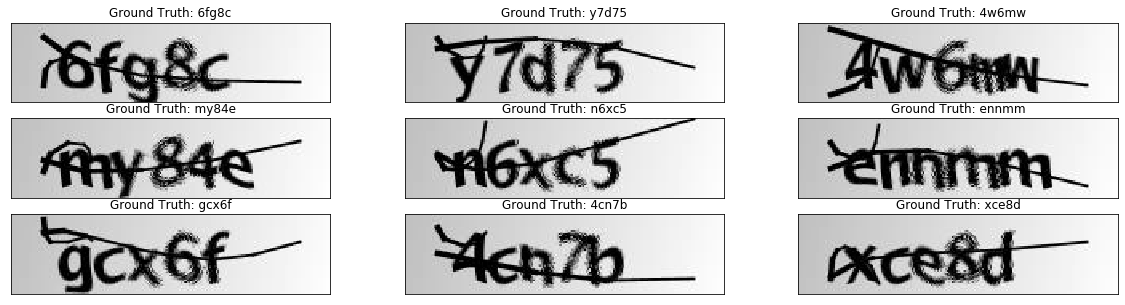

In [7]:
# show sample images
fig = plt.figure(figsize=(20, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(examples[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(examples[i][1]))
    plt.xticks([])
    plt.yticks([])

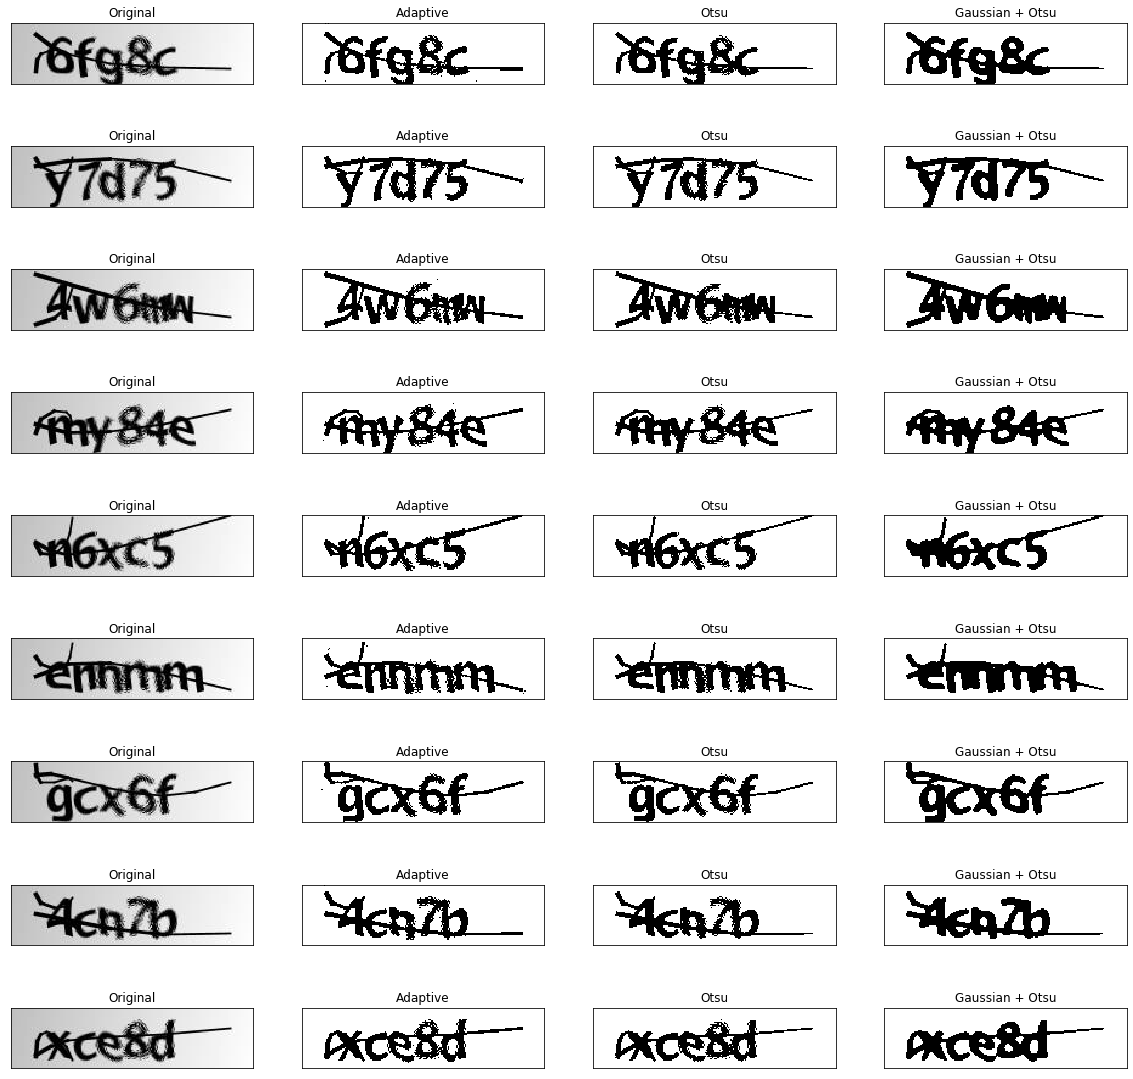

In [8]:
# show sample images
fig = plt.figure(figsize=(20, 20))
data_thres = []
for i in range(9):
    img = examples[i][0]
    # Adaptive thresholding
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

    # Otsu thresholding
    ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Otsu thresholding with Gaussian Blur
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    #Plot
    titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
    images = [img, th, th2, th3]
    data_thres.append(images)
    for j in range(4):
        plt.subplot(9, 4, i*4 + j + 1), plt.imshow(images[j], 'gray')
        plt.title(titles[j])
        plt.xticks([]), plt.yticks([])
plt.show()

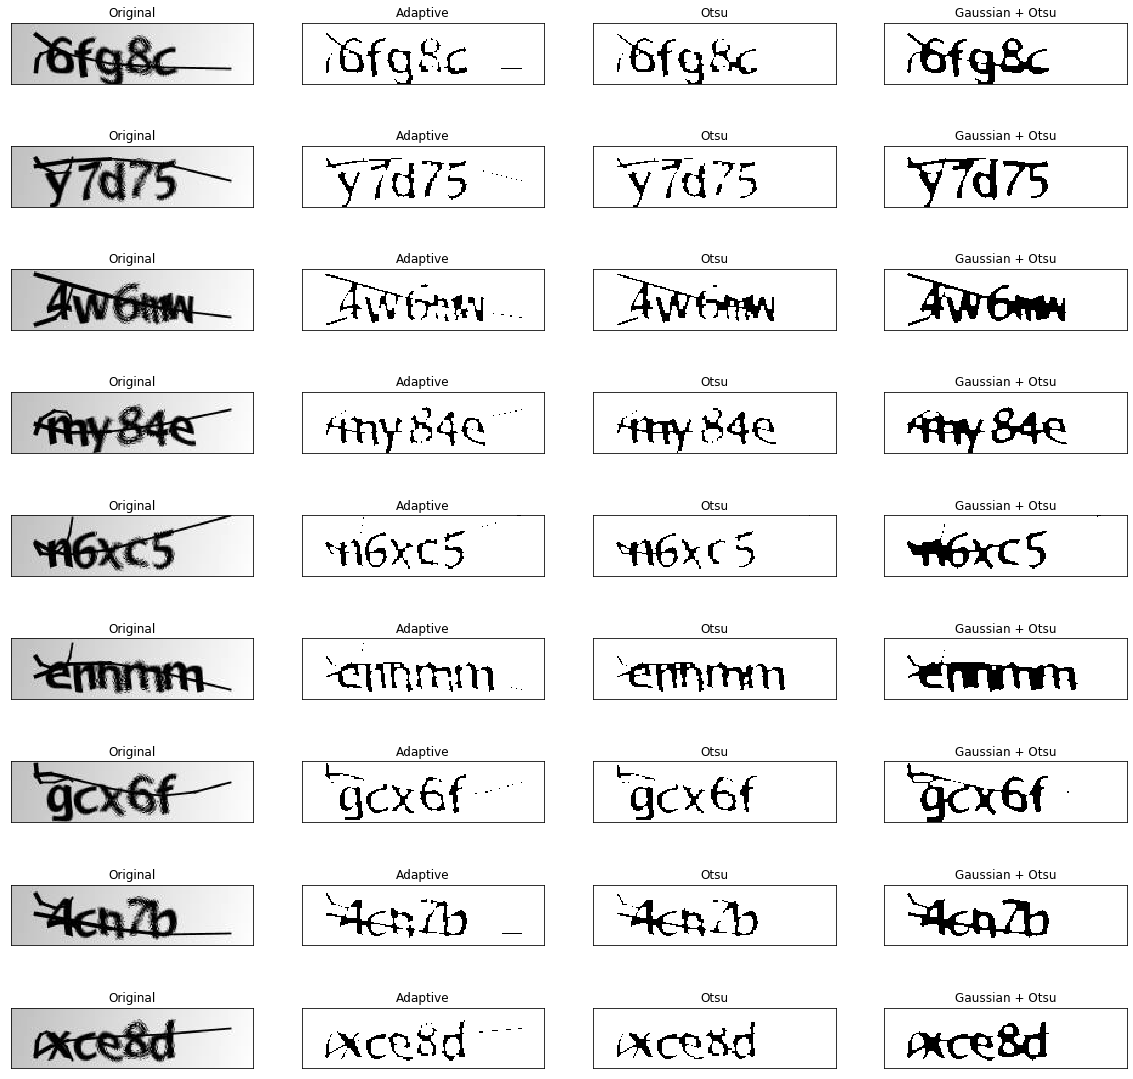

In [9]:
# show sample images
fig = plt.figure(figsize=(20, 20))
data_dil = []
for i in range(9):
    img = data_thres[i][0]
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(data_thres[i][1], kernel, iterations=1)
    dilation2 = cv2.dilate(data_thres[i][2], kernel, iterations=1)
    dilation3 = cv2.dilate(data_thres[i][3], kernel, iterations=1)

    titles2 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
    images2 = [img, dilation, dilation2, dilation3]
    
    data_dil.append(images2)

    for j in range(4):
        plt.subplot(9, 4, i*4 + j + 1), plt.imshow(images2[j], 'gray')
        plt.title(titles2[j])
        plt.xticks([]), plt.yticks([])
        
plt.show()

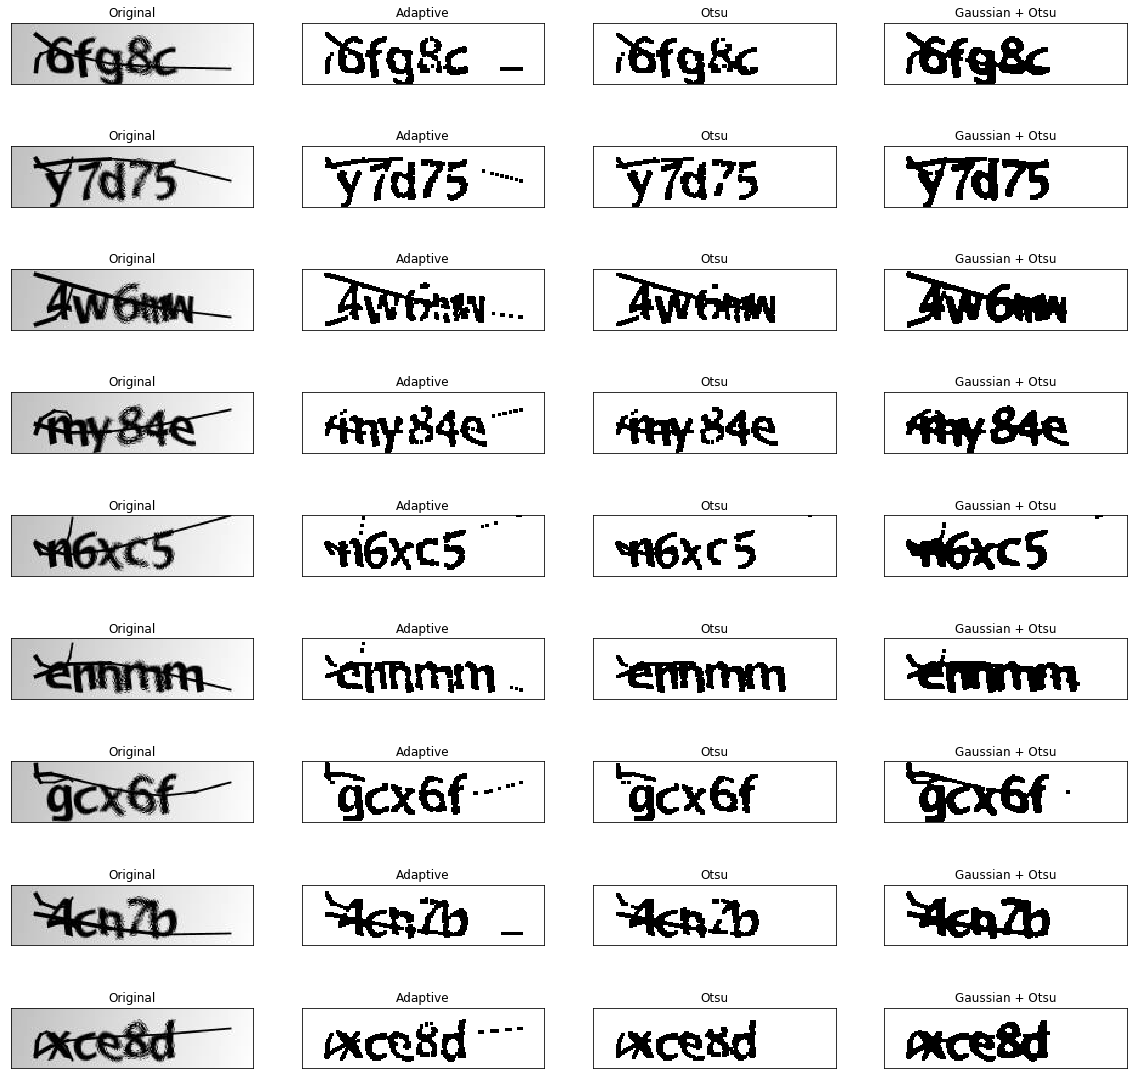

In [10]:
# show sample images
fig = plt.figure(figsize=(20, 20))
data_ero = []
for i in range(9):
    img = data_dil[i][0]
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.erode(data_dil[i][1], kernel, iterations=1)
    dilation2 = cv2.erode(data_dil[i][2], kernel, iterations=1)
    dilation3 = cv2.erode(data_dil[i][3], kernel, iterations=1)

    titles3 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
    images3 = [img, dilation, dilation2, dilation3]
    
    data_ero.append(images3)

    for j in range(4):
        plt.subplot(9, 4, i*4 + j + 1), plt.imshow(images3[j], 'gray')
        plt.title(titles3[j])
        plt.xticks([]), plt.yticks([])
        
plt.show()

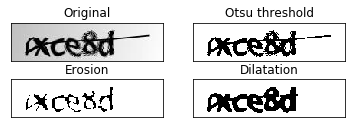

In [13]:
plt.subplot(4, 2, 1), plt.imshow(images2[0], 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(4, 2, 2), plt.imshow(images[2], 'gray')
plt.title('Otsu threshold')
plt.xticks([]), plt.yticks([])
plt.subplot(4, 2, 3), plt.imshow(images2[2], 'gray')
plt.title('Erosion')
plt.xticks([]), plt.yticks([])
plt.subplot(4, 2, 4), plt.imshow(images3[3], 'gray')
plt.title('Dilatation')
plt.xticks([]), plt.yticks([])
plt.savefig(os.path.join(image_dir, 'preproc.png'), bbox_inches='tight')
plt.show()

# References

https://www.kaggle.com/fournierp/opencv-word-segmenting-on-captcha-images

https://stackoverflow.com/questions/10964226/how-to-convert-an-image-into-character-segments